<a href="https://colab.research.google.com/github/Tasfia-007/The-Wiser-Project/blob/main/noise_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:


# Step 1: Run this cell first to install all necessary packages.
# After this finishes, you MUST restart the runtime.
# Go to the menu: Runtime -> Restart session
!pip install -q qiskit qiskit-aer matplotlib pylatexenc
!pip install qiskit-ibm-runtime
print("✅ All packages installed successfully. Please restart the runtime now.")



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 94.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.2/366.2 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 8.8 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninsta


--- Circuit Information for 5-Layer QGB ---
Circuit depth: 67
Number of qubits: 12
Number of classical bits: 6

Circuit diagram:

=== IDEAL SIMULATION ===


/tmp/ipython-input-4095284509.py:366: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  ideal_dist, noisy_dist, noise_model, transpiled_circuit = compare_ideal_vs_noisy(qgb_circuit, N_LAYERS, SHOTS, TEST_DEVICE) # Capture transpiled_circuit here


Ideal Results (Probabilities):
{0: 0.6907958984375, 1: 0.2685546875, 2: 0.03759765625, 3: 0.0029296875, 4: 0.0001220703125, 5: 0.0}

=== NOISY SIMULATION ===
Using device: fake_torino
Circuit requires 12 qubits, device has 133 qubits
High optimization failed: 'A connected component of the DAGCircuit is too large for any of the connected components in the coupling map'
Trying with coupling map disabled...
Original circuit depth: 67
Transpiled circuit depth: 782
Number of qubits on device: 133
Noisy Results (Probabilities):
{0: 0.5728759765625, 1: 0.24072265625, 2: 0.0794677734375, 3: 0.01806640625, 4: 0.0037841796875, 5: 0.00341796875}


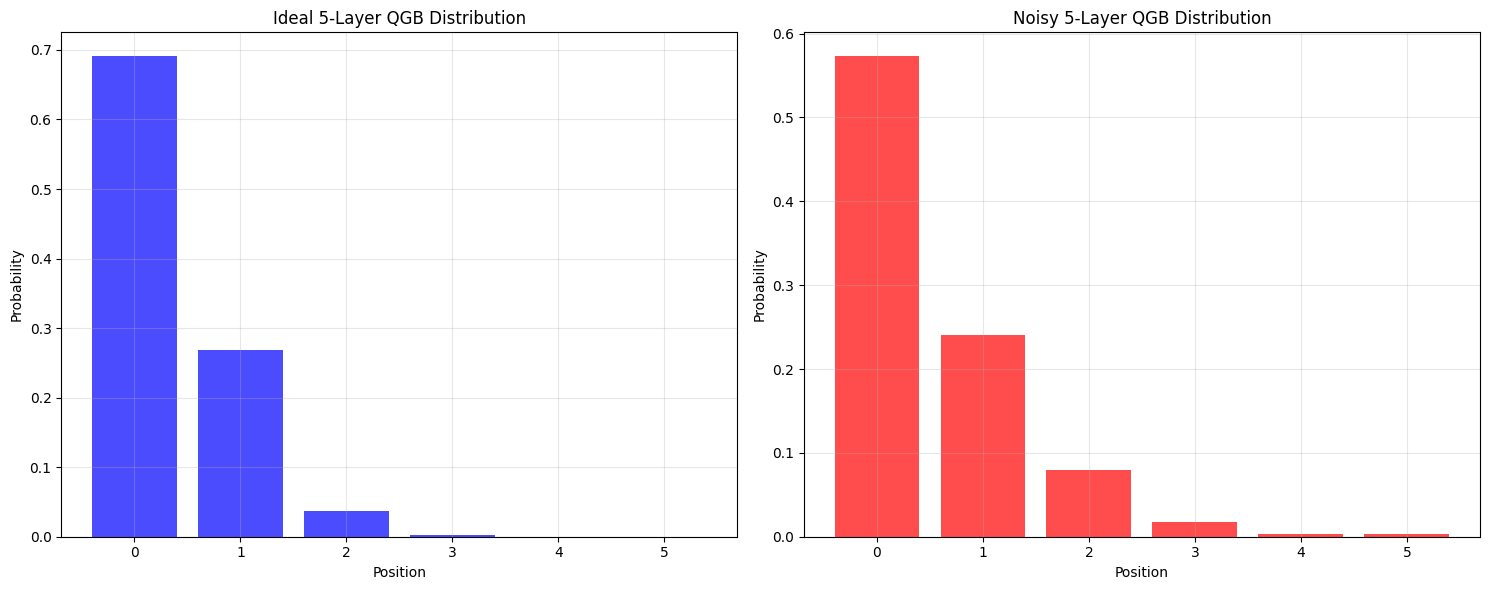

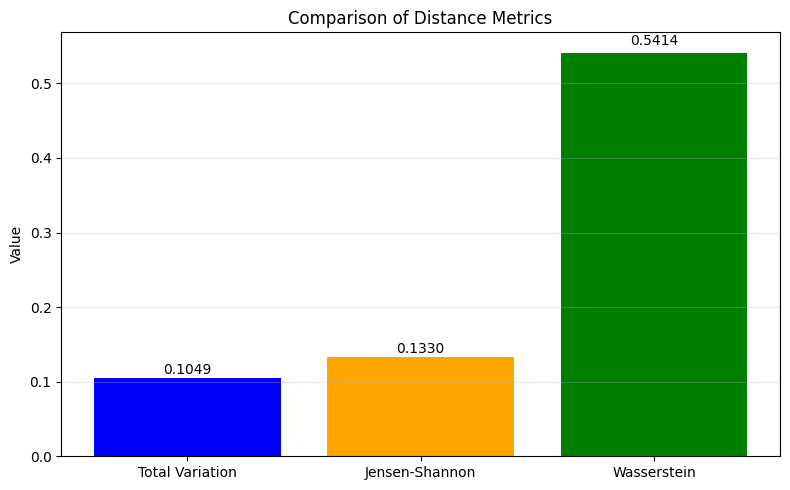


All results and images saved inside folder: 'torino-exponential'


In [4]:
import os
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer.primitives import Sampler
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeManhattanV2, FakeTorino,FakeKawasaki,FakeOsaka,FakeTorino,FakeMarrakesh
from qiskit_aer.noise import NoiseModel
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from collections import defaultdict
import os
import math # Import math for jensen_shannon_divergence


try:
    from IPython.display import display
    IS_IPYTHON = True
except ImportError:
    IS_IPYTHON = False

# --- Define the missing distance functions and plot function ---
def total_variation_distance(p, q):
    """Calculates the Total Variation Distance between two probability distributions."""
    keys = sorted(list(set(p.keys()).union(set(q.keys()))))
    tvd = 0.0
    for key in keys:
        tvd += abs(p.get(key, 0.0) - q.get(key, 0.0))
    return tvd / 2.0

def jensen_shannon_divergence(p, q):
    """Calculates the Jensen-Shannon Divergence between two probability distributions."""
    keys = sorted(list(set(p.keys()).union(set(q.keys()))))
    m = defaultdict(float)
    for key in keys:
        m[key] = (p.get(key, 0.0) + q.get(key, 0.0)) / 2.0

    jsd = 0.0
    for key in keys:
        if p.get(key, 0.0) > 0:
            jsd += p.get(key, 0.0) * math.log2(p.get(key, 0.0) / m[key])
        if q.get(key, 0.0) > 0:
            jsd += q.get(key, 0.0) * math.log2(q.get(key, 0.0) / m[key])

    return math.sqrt(jsd / 2.0)

def wasserstein_distance(p, q):
    """Calculates the 1D Wasserstein Distance between two probability distributions."""
    keys = sorted(list(set(p.keys()).union(set(q.keys()))))
    cdf_p = {}
    cdf_q = {}
    current_cdf_p = 0.0
    current_cdf_q = 0.0

    for key in keys:
        current_cdf_p += p.get(key, 0.0)
        current_cdf_q += q.get(key, 0.0)
        cdf_p[key] = current_cdf_p
        cdf_q[key] = current_cdf_q

    wd = 0.0
    prev_key = keys[0]
    for i in range(1, len(keys)):
        key = keys[i]
        wd += (key - prev_key) * abs(cdf_p[prev_key] - cdf_q[prev_key])
        prev_key = key

    return wd


def plot_distance_metrics(distances):
    """Plots a bar chart of distance metrics."""
    names = list(distances.keys())
    values = list(distances.values())

    plt.figure(figsize=(8, 5))
    bars = plt.bar(names, values, color=['blue', 'orange', 'green'])
    plt.title('Comparison of Distance Metrics')
    plt.ylabel('Value')
    plt.grid(axis='y', alpha=0.3)
    for bar, val in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() * 1.01,
                 f"{val:.4f}", ha='center', va='bottom')
    plt.tight_layout()
    if IS_IPYTHON:
        display(plt.gcf())
    else:
        plt.show()
    plt.close()

# --- Original functions from the cell ---
def create_exponential_dist(n_layers: int, target_distribution="exponential_custom"):
    """
    Generates a Qiskit QuantumCircuit for an N-layer Quantum Galton Board with a left-skewed exponential distribution.
    """
    num_working_qubits = 2 * n_layers + 1
    num_qubits = num_working_qubits + 1
    num_clbits = n_layers + 1

    qc = QuantumCircuit(num_qubits, num_clbits, name=f"{n_layers}-Layer QGB")

    control_qubit = 0

    # --- Step 1: Initialization ---
    initial_ball_pos = n_layers + 1
    qc.x(initial_ball_pos)

    qc.barrier()

    # --- Step 2: Build the Layers ---
    for layer in range(n_layers):
        qc.reset(control_qubit)

        base_bias = 30 * (np.pi/180)
        qc.rx(base_bias, control_qubit)

        peg_positions = range(n_layers + 1 - layer, n_layers + 1 + layer + 1, 2)

        for i, peg_pos in enumerate(peg_positions):
            left_channel = peg_pos - 1
            right_channel = peg_pos + 1

            qc.cswap(control_qubit, left_channel, peg_pos)
            qc.cx(peg_pos, control_qubit)
            qc.cswap(control_qubit, peg_pos, right_channel)

            if i < len(peg_positions) - 1:
                qc.cx(right_channel, control_qubit)

        qc.barrier()

    # --- Step 3: Measurement ---
    output_qubits = range(1, num_working_qubits + 2, 2)
    qc.measure(output_qubits, range(num_clbits))

    return qc

def get_available_devices():
    """
    List available fake backend devices
    """
    devices = {
        'manhattan': FakeTorino,
        'torino': FakeTorino,
    }
    return devices

def run_noisy_simulation(circuit, shots=8192, device_name='manhattan'):
    """
    Run the circuit with device noise model simulation
    """
    # Get available devices
    devices = get_available_devices()

    # Create fake device backend
    if device_name.lower() in devices:
        fake_device = devices[device_name.lower()]()
    else:
        print(f"Unknown device '{device_name}'. Available devices: {list(devices.keys())}")
        print("Using default: FakeManhattanV2")
        fake_device = FakeManhattanV2()

    print(f"Using device: {fake_device.name}")
    print(f"Circuit requires {circuit.num_qubits} qubits, device has {fake_device.num_qubits} qubits")

    # Check if circuit fits on device
    if circuit.num_qubits > fake_device.num_qubits:
        print(f"WARNING: Circuit needs {circuit.num_qubits} qubits but device only has {fake_device.num_qubits}")
        print("Falling back to noise-model-only simulation (no coupling map constraints)")

        # Create noise model from the fake device
        noise_model = NoiseModel.from_backend(fake_device)

        # Create AerSimulator with noise model
        sim_noisy = AerSimulator(noise_model=noise_model)

        # Transpile with basic optimization only
        transpiled_circuit = transpile(circuit, sim_noisy, optimization_level=3)

    else:
        # Create noise model from the fake device
        noise_model = NoiseModel.from_backend(fake_device)

        # Get device properties
        coupling_map = fake_device.coupling_map
        basis_gates = fake_device.basis_gates

        # Create AerSimulator with noise model
        sim_noisy = AerSimulator(
            noise_model=noise_model,
            coupling_map=coupling_map,
            basis_gates=basis_gates
        )

        # Transpile circuit for the noisy backend with higher optimization
        try:
            transpiled_circuit = transpile(circuit, sim_noisy, optimization_level=3)
        except Exception as e:
            print(f"High optimization failed: {e}")
            print("Trying with coupling map disabled...")
            sim_noisy = AerSimulator(noise_model=noise_model)
            transpiled_circuit = transpile(circuit, sim_noisy, optimization_level=3)


    print(f"Original circuit depth: {circuit.depth()}")
    print(f"Transpiled circuit depth: {transpiled_circuit.depth()}")
    print(f"Number of qubits on device: {fake_device.num_qubits}")

    # Run the noisy simulation
    job = sim_noisy.run(transpiled_circuit, shots=shots)
    result = job.result()
    counts = result.get_counts(0)

    return counts, noise_model, transpiled_circuit # Return transpiled_circuit


def compare_ideal_vs_noisy(circuit, n_layers, shots=8192, device_name='manhattan'):
    """
    Compare ideal simulation vs noisy simulation results
    """
    print("=== IDEAL SIMULATION ===")

    # Use the original Sampler (V1) for compatibility
    sampler = Sampler()
    job = sampler.run(circuit, shots=shots)
    result = job.result()

    # Get counts from the result
    counts_data = result.quasi_dists[0]

    # Convert quasi-distribution to counts and then to probabilities
    ideal_distribution = defaultdict(float, {i: 0.0 for i in range(n_layers + 1)})

    for outcome, probability in counts_data.items():
        # Convert integer outcome to binary string
        bitstring = format(outcome, f'0{n_layers + 1}b')
        try:
            position = bitstring.index('1')
            ideal_distribution[position] += probability
        except ValueError:
            pass

    print("Ideal Results (Probabilities):")
    print({k: v for k, v in sorted(ideal_distribution.items())})

    print("\n=== NOISY SIMULATION ===")
    # Run noisy simulation and get transpiled circuit
    noisy_counts, noise_model, transpiled_circuit = run_noisy_simulation(circuit, shots, device_name)

    # Convert counts to probabilities
    total_shots = sum(noisy_counts.values())
    noisy_distribution = defaultdict(float, {i: 0.0 for i in range(n_layers + 1)})

    for bitstring, count in noisy_counts.items():
        prob = count / total_shots
        try:
            position = bitstring.index('1')
            noisy_distribution[position] += prob
        except ValueError:
            pass

    print("Noisy Results (Probabilities):")
    print({k: v for k, v in sorted(noisy_distribution.items())})

    # Plot comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Ideal histogram
    positions = list(ideal_distribution.keys())
    probabilities = list(ideal_distribution.values())
    ax1.bar(positions, probabilities, alpha=0.7, color='blue')
    ax1.set_title(f'Ideal {n_layers}-Layer QGB Distribution')
    ax1.set_xlabel('Position')
    ax1.set_ylabel('Probability')
    ax1.grid(True, alpha=0.3)

    # Noisy histogram
    positions_noisy = list(noisy_distribution.keys())
    probabilities_noisy = list(noisy_distribution.values())
    ax2.bar(positions_noisy, probabilities_noisy, alpha=0.7, color='red')
    ax2.set_title(f'Noisy {n_layers}-Layer QGB Distribution')
    ax2.set_xlabel('Position')
    ax2.set_ylabel('Probability')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save the figure object before displaying or closing
    dist_plot_path = os.path.join(folder_name, f'{n_layers}_layers_qgb.png')
    fig.savefig(dist_plot_path)


    if IS_IPYTHON:
        display(fig)
    else:
        plt.show()
    plt.close(fig) # Close the figure after saving and displaying


    return ideal_distribution, noisy_distribution, noise_model, transpiled_circuit # Return transpiled_circuit


# Additions for saving results and images
def ensure_folder(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)


def save_circuit_diagram(circuit, filepath):
    # Draw circuit diagram using mpl and save figure
    fig = circuit.draw(output='mpl')
    fig.savefig(filepath)
    plt.close(fig)


def save_results_text(filepath, n_layers, device_name, ideal_dist, noisy_dist, tvd, jsd, wd, noise_model, circuit, transpiled_circuit):
    with open(filepath, 'w') as f:
        f.write(f"--- Comparing Ideal vs Noisy Simulation for {n_layers}-Layer QGB ---\n\n")
        f.write("=== IDEAL SIMULATION ===\n")
        f.write(f"Ideal Results (Probabilities):\n{dict(sorted(ideal_dist.items()))}\n\n")
        f.write("=== NOISY SIMULATION ===\n")
        f.write(f"Using device: {device_name}\n")
        f.write(f"Circuit qubits: {circuit.num_qubits}, Device qubits: Unknown\n") # Device qubits might be unknown if falling back to noise-model-only
        f.write(f"Original circuit depth: {circuit.depth()}\n")
        f.write(f"Transpiled circuit depth: {transpiled_circuit.depth()}\n\n") # This line now receives a QuantumCircuit object
        f.write(f"Noisy Results (Probabilities):\n{dict(sorted(noisy_dist.items()))}\n\n")
        f.write("--- Noise Model Information ---\n")
        f.write(f"Device used: {device_name}\n")
        f.write(f"Noise model type: {type(noise_model)}\n")
        f.write(f"Number of noise instructions: "
                f"{len(noise_model._noise_instructions) if hasattr(noise_model, '_noise_instructions') else 'N/A'}\n\n")
        f.write("--- Difference Analysis ---\n")
        for pos in range(n_layers + 1):
            ideal_prob = ideal_dist.get(pos, 0.0)
            noisy_prob = noisy_dist.get(pos, 0.0)
            diff = abs(ideal_prob - noisy_prob)
            f.write(f"Position {pos}: Ideal={ideal_prob:.4f}, Noisy={noisy_prob:.4f}, Diff={diff:.4f}\n")
        f.write(f"\nTotal Variation Distance: {tvd:.4f}\n")
        f.write(f"Jensen-Shannon Divergence: {jsd:.4f}\n")
        f.write(f"Wasserstein Distance: {wd:.4f}\n")


# --- Main program execution with added saving ---

if __name__ == '__main__':
    N_LAYERS = 5

    TEST_DEVICE = 'torino'
    SHOTS = 8192

    # Create the QGB circuit
    qgb_circuit =create_exponential_dist(N_LAYERS)

    # Prepare folder name based on device and gaussian
    folder_name = f"{TEST_DEVICE}-exponential"
    ensure_folder(folder_name)

    # Print circuit stats and diagram
    print(f"\n--- Circuit Information for {N_LAYERS}-Layer QGB ---")
    print(f"Circuit depth: {qgb_circuit.depth()}")
    print(f"Number of qubits: {qgb_circuit.num_qubits}")
    print(f"Number of classical bits: {qgb_circuit.num_clbits}\n")
    print("Circuit diagram:\n")
    # print(qgb_circuit.draw(fold=120)) # Drawing to console can be messy for large circuits

    # Run simulations and get results, including the transpiled circuit
    ideal_dist, noisy_dist, noise_model, transpiled_circuit = compare_ideal_vs_noisy(qgb_circuit, N_LAYERS, SHOTS, TEST_DEVICE) # Capture transpiled_circuit here

    # Calculate distances
    tvd = total_variation_distance(ideal_dist, noisy_dist)
    jsd = jensen_shannon_divergence(ideal_dist, noisy_dist)
    wd = wasserstein_distance(ideal_dist, noisy_dist)

    # Plot distance metrics
    plot_distance_metrics({
        'Total Variation': tvd,
        'Jensen-Shannon': jsd,
        'Wasserstein': wd
    })

    # Save plots to the folder
    # The distribution plot is now saved within compare_ideal_vs_noisy

    # Plot and save distance metrics graph
    plt.figure(figsize=(8, 5))
    names = ['Total Variation', 'Jensen-Shannon', 'Wasserstein']
    values = [tvd, jsd, wd]
    bars = plt.bar(names, values, color=['blue', 'orange', 'green'])
    plt.title('Comparison of Distance Metrics')
    plt.ylabel('Value')
    plt.grid(axis='y', alpha=0.3)
    for bar, val in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() * 1.01,
                 f"{val:.4f}", ha='center', va='bottom')
    plt.tight_layout()
    distance_plot_path = os.path.join(folder_name, 'distance.png')
    plt.savefig(distance_plot_path)
    plt.close()

    # Save results text file
    results_txt_path = os.path.join(folder_name, 'results.txt')
    save_results_text(results_txt_path, N_LAYERS, TEST_DEVICE, ideal_dist, noisy_dist, tvd, jsd, wd, noise_model, qgb_circuit, transpiled_circuit=transpiled_circuit) # Corrected: pass transpiled_circuit

    # Save circuit diagrams:
    original_circuit_path = os.path.join(folder_name, 'original_circuit.mpl.png')
    transpiled_circuit_path = os.path.join(folder_name, 'transpiled_circuit.mpl.png')

    save_circuit_diagram(qgb_circuit, original_circuit_path)
    save_circuit_diagram(transpiled_circuit, transpiled_circuit_path)


    print(f"\nAll results and images saved inside folder: '{folder_name}'")

gaussian


In [ ]:
import os
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer.primitives import Sampler
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeManhattanV2, FakeTorino,FakeKawasaki,FakeOsaka,FakeTorino,FakeMarrakesh
from qiskit_aer.noise import NoiseModel
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from collections import defaultdict
import os
import math # Import math for jensen_shannon_divergence


try:
    from IPython.display import display
    IS_IPYTHON = True
except ImportError:
    IS_IPYTHON = False

# --- Define the missing distance functions and plot function ---
def total_variation_distance(p, q):
    """Calculates the Total Variation Distance between two probability distributions."""
    keys = sorted(list(set(p.keys()).union(set(q.keys()))))
    tvd = 0.0
    for key in keys:
        tvd += abs(p.get(key, 0.0) - q.get(key, 0.0))
    return tvd / 2.0

def jensen_shannon_divergence(p, q):
    """Calculates the Jensen-Shannon Divergence between two probability distributions."""
    keys = sorted(list(set(p.keys()).union(set(q.keys()))))
    m = defaultdict(float)
    for key in keys:
        m[key] = (p.get(key, 0.0) + q.get(key, 0.0)) / 2.0

    jsd = 0.0
    for key in keys:
        if p.get(key, 0.0) > 0:
            jsd += p.get(key, 0.0) * math.log2(p.get(key, 0.0) / m[key])
        if q.get(key, 0.0) > 0:
            jsd += q.get(key, 0.0) * math.log2(q.get(key, 0.0) / m[key])

    return math.sqrt(jsd / 2.0)

def wasserstein_distance(p, q):
    """Calculates the 1D Wasserstein Distance between two probability distributions."""
    keys = sorted(list(set(p.keys()).union(set(q.keys()))))
    cdf_p = {}
    cdf_q = {}
    current_cdf_p = 0.0
    current_cdf_q = 0.0

    for key in keys:
        current_cdf_p += p.get(key, 0.0)
        current_cdf_q += q.get(key, 0.0)
        cdf_p[key] = current_cdf_p
        cdf_q[key] = current_cdf_q

    wd = 0.0
    prev_key = keys[0]
    for i in range(1, len(keys)):
        key = keys[i]
        wd += (key - prev_key) * abs(cdf_p[prev_key] - cdf_q[prev_key])
        prev_key = key

    return wd


def plot_distance_metrics(distances):
    """Plots a bar chart of distance metrics."""
    names = list(distances.keys())
    values = list(distances.values())

    plt.figure(figsize=(8, 5))
    bars = plt.bar(names, values, color=['blue', 'orange', 'green'])
    plt.title('Comparison of Distance Metrics')
    plt.ylabel('Value')
    plt.grid(axis='y', alpha=0.3)
    for bar, val in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() * 1.01,
                 f"{val:.4f}", ha='center', va='bottom')
    plt.tight_layout()
    if IS_IPYTHON:
        display(plt.gcf())
    else:
        plt.show()
    plt.close()

# --- Original functions from the cell ---
def create_n_layer_qgb(n_layers: int):
    """
    Generates an optimized Qiskit QuantumCircuit for an N-layer Quantum Galton Board.

    Args:
        n_layers: The number of peg layers in the Galton board.

    Returns:
        A Qiskit QuantumCircuit object for the N-layer QGB.
    """
    num_working_qubits = 2 * n_layers + 1
    num_qubits = num_working_qubits + 1
    num_clbits = n_layers + 1

    qc = QuantumCircuit(num_qubits, num_clbits, name=f"{n_layers}-Layer QGB")

    control_qubit = 0

    # --- Step 1: Initialization ---
    initial_ball_pos = n_layers + 1
    qc.x(initial_ball_pos)
    # Prepare control qubit for the first layer
    qc.h(control_qubit)
    qc.barrier()

    # --- Step 2: Build the Layers ---
    for layer in range(n_layers):
        # --- Peg Logic for the current layer ---
        peg_positions = range(n_layers + 1 - layer, n_layers + 1 + layer + 1, 2)

        for i, peg_pos in enumerate(peg_positions):
            left_channel = peg_pos - 1
            right_channel = peg_pos + 1

            # Apply the standard "quantum peg" logic
            qc.cswap(control_qubit, left_channel, peg_pos)
            qc.cx(peg_pos, control_qubit)
            qc.cswap(control_qubit, peg_pos, right_channel)

            # Rebalancing CNOT for pegs within the same layer
            if i < len(peg_positions) - 1:
                qc.cx(right_channel, control_qubit)

        qc.barrier()

        # --- OPTIMIZED Control Qubit Preparation for the *next* layer ---
        if layer < n_layers - 1:  # No need to prepare after the last layer
            if layer == 0:
                # After layer 0 (1 peg), control qubit is in state |1>.
                # Optimize by flipping to |0> then applying Hadamard.
                # This is more efficient than a full reset.
                qc.x(control_qubit)
                qc.h(control_qubit)
            else:
                # For subsequent layers, state is entangled. Reset is cleanest.
                qc.reset(control_qubit)
                qc.h(control_qubit)
            qc.barrier()

    # --- Step 3: Measurement ---
    output_qubits = range(1, num_working_qubits + 2, 2)
    qc.measure(output_qubits, range(num_clbits))

    return qc
def get_available_devices():
    """
    List available fake backend devices
    """
    devices = {
        'manhattan': FakeTorino,
        'torino': FakeTorino,
    }
    return devices

def run_noisy_simulation(circuit, shots=8192, device_name='manhattan'):
    """
    Run the circuit with device noise model simulation
    """
    # Get available devices
    devices = get_available_devices()

    # Create fake device backend
    if device_name.lower() in devices:
        fake_device = devices[device_name.lower()]()
    else:
        print(f"Unknown device '{device_name}'. Available devices: {list(devices.keys())}")
        print("Using default: FakeManhattanV2")
        fake_device = FakeManhattanV2()

    print(f"Using device: {fake_device.name}")
    print(f"Circuit requires {circuit.num_qubits} qubits, device has {fake_device.num_qubits} qubits")

    # Check if circuit fits on device
    if circuit.num_qubits > fake_device.num_qubits:
        print(f"WARNING: Circuit needs {circuit.num_qubits} qubits but device only has {fake_device.num_qubits}")
        print("Falling back to noise-model-only simulation (no coupling map constraints)")

        # Create noise model from the fake device
        noise_model = NoiseModel.from_backend(fake_device)

        # Create AerSimulator with noise model
        sim_noisy = AerSimulator(noise_model=noise_model)

        # Transpile with basic optimization only
        transpiled_circuit = transpile(circuit, sim_noisy, optimization_level=3)

    else:
        # Create noise model from the fake device
        noise_model = NoiseModel.from_backend(fake_device)

        # Get device properties
        coupling_map = fake_device.coupling_map
        basis_gates = fake_device.basis_gates

        # Create AerSimulator with noise model
        sim_noisy = AerSimulator(
            noise_model=noise_model,
            coupling_map=coupling_map,
            basis_gates=basis_gates
        )

        # Transpile circuit for the noisy backend with higher optimization
        try:
            transpiled_circuit = transpile(circuit, sim_noisy, optimization_level=3)
        except Exception as e:
            print(f"High optimization failed: {e}")
            print("Trying with coupling map disabled...")
            sim_noisy = AerSimulator(noise_model=noise_model)
            transpiled_circuit = transpile(circuit, sim_noisy, optimization_level=3)


    print(f"Original circuit depth: {circuit.depth()}")
    print(f"Transpiled circuit depth: {transpiled_circuit.depth()}")
    print(f"Number of qubits on device: {fake_device.num_qubits}")

    # Run the noisy simulation
    job = sim_noisy.run(transpiled_circuit, shots=shots)
    result = job.result()
    counts = result.get_counts(0)

    return counts, noise_model, transpiled_circuit # Return transpiled_circuit


def compare_ideal_vs_noisy(circuit, n_layers, shots=8192, device_name='manhattan'):
    """
    Compare ideal simulation vs noisy simulation results
    """
    print("=== IDEAL SIMULATION ===")

    # Use the original Sampler (V1) for compatibility
    sampler = Sampler()
    job = sampler.run(circuit, shots=shots)
    result = job.result()

    # Get counts from the result
    counts_data = result.quasi_dists[0]

    # Convert quasi-distribution to counts and then to probabilities
    ideal_distribution = defaultdict(float, {i: 0.0 for i in range(n_layers + 1)})

    for outcome, probability in counts_data.items():
        # Convert integer outcome to binary string
        bitstring = format(outcome, f'0{n_layers + 1}b')
        try:
            position = bitstring.index('1')
            ideal_distribution[position] += probability
        except ValueError:
            pass

    print("Ideal Results (Probabilities):")
    print({k: v for k, v in sorted(ideal_distribution.items())})

    print("\n=== NOISY SIMULATION ===")
    # Run noisy simulation and get transpiled circuit
    noisy_counts, noise_model, transpiled_circuit = run_noisy_simulation(circuit, shots, device_name)

    # Convert counts to probabilities
    total_shots = sum(noisy_counts.values())
    noisy_distribution = defaultdict(float, {i: 0.0 for i in range(n_layers + 1)})

    for bitstring, count in noisy_counts.items():
        prob = count / total_shots
        try:
            position = bitstring.index('1')
            noisy_distribution[position] += prob
        except ValueError:
            pass

    print("Noisy Results (Probabilities):")
    print({k: v for k, v in sorted(noisy_distribution.items())})

    # Plot comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Ideal histogram
    positions = list(ideal_distribution.keys())
    probabilities = list(ideal_distribution.values())
    ax1.bar(positions, probabilities, alpha=0.7, color='blue')
    ax1.set_title(f'Ideal {n_layers}-Layer QGB Distribution')
    ax1.set_xlabel('Position')
    ax1.set_ylabel('Probability')
    ax1.grid(True, alpha=0.3)

    # Noisy histogram
    positions_noisy = list(noisy_distribution.keys())
    probabilities_noisy = list(noisy_distribution.values())
    ax2.bar(positions_noisy, probabilities_noisy, alpha=0.7, color='red')
    ax2.set_title(f'Noisy {n_layers}-Layer QGB Distribution')
    ax2.set_xlabel('Position')
    ax2.set_ylabel('Probability')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save the figure object before displaying or closing
    dist_plot_path = os.path.join(folder_name, f'{n_layers}_layers_qgb.png')
    fig.savefig(dist_plot_path)


    if IS_IPYTHON:
        display(fig)
    else:
        plt.show()
    plt.close(fig) # Close the figure after saving and displaying


    return ideal_distribution, noisy_distribution, noise_model, transpiled_circuit # Return transpiled_circuit


# Additions for saving results and images
def ensure_folder(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)


def save_circuit_diagram(circuit, filepath):
    # Draw circuit diagram using mpl and save figure
    fig = circuit.draw(output='mpl')
    fig.savefig(filepath)
    plt.close(fig)


def save_results_text(filepath, n_layers, device_name, ideal_dist, noisy_dist, tvd, jsd, wd, noise_model, circuit, transpiled_circuit):
    with open(filepath, 'w') as f:
        f.write(f"--- Comparing Ideal vs Noisy Simulation for {n_layers}-Layer QGB ---\n\n")
        f.write("=== IDEAL SIMULATION ===\n")
        f.write(f"Ideal Results (Probabilities):\n{dict(sorted(ideal_dist.items()))}\n\n")
        f.write("=== NOISY SIMULATION ===\n")
        f.write(f"Using device: {device_name}\n")
        f.write(f"Circuit qubits: {circuit.num_qubits}, Device qubits: Unknown\n") # Device qubits might be unknown if falling back to noise-model-only
        f.write(f"Original circuit depth: {circuit.depth()}\n")
        f.write(f"Transpiled circuit depth: {transpiled_circuit.depth()}\n\n") # This line now receives a QuantumCircuit object
        f.write(f"Noisy Results (Probabilities):\n{dict(sorted(noisy_dist.items()))}\n\n")
        f.write("--- Noise Model Information ---\n")
        f.write(f"Device used: {device_name}\n")
        f.write(f"Noise model type: {type(noise_model)}\n")
        f.write(f"Number of noise instructions: "
                f"{len(noise_model._noise_instructions) if hasattr(noise_model, '_noise_instructions') else 'N/A'}\n\n")
        f.write("--- Difference Analysis ---\n")
        for pos in range(n_layers + 1):
            ideal_prob = ideal_dist.get(pos, 0.0)
            noisy_prob = noisy_dist.get(pos, 0.0)
            diff = abs(ideal_prob - noisy_prob)
            f.write(f"Position {pos}: Ideal={ideal_prob:.4f}, Noisy={noisy_prob:.4f}, Diff={diff:.4f}\n")
        f.write(f"\nTotal Variation Distance: {tvd:.4f}\n")
        f.write(f"Jensen-Shannon Divergence: {jsd:.4f}\n")
        f.write(f"Wasserstein Distance: {wd:.4f}\n")


# --- Main program execution with added saving ---

if __name__ == '__main__':
    N_LAYERS = 5

    TEST_DEVICE = 'torino'
    SHOTS = 8192

    # Create the QGB circuit
    qgb_circuit =create_n_layer_qgb(N_LAYERS)

    # Prepare folder name based on device and gaussian
    folder_name = f"{TEST_DEVICE}-exponential"
    ensure_folder(folder_name)

    # Print circuit stats and diagram
    print(f"\n--- Circuit Information for {N_LAYERS}-Layer QGB ---")
    print(f"Circuit depth: {qgb_circuit.depth()}")
    print(f"Number of qubits: {qgb_circuit.num_qubits}")
    print(f"Number of classical bits: {qgb_circuit.num_clbits}\n")
    print("Circuit diagram:\n")
    # print(qgb_circuit.draw(fold=120)) # Drawing to console can be messy for large circuits

    # Run simulations and get results, including the transpiled circuit
    ideal_dist, noisy_dist, noise_model, transpiled_circuit = compare_ideal_vs_noisy(qgb_circuit, N_LAYERS, SHOTS, TEST_DEVICE) # Capture transpiled_circuit here

    # Calculate distances
    tvd = total_variation_distance(ideal_dist, noisy_dist)
    jsd = jensen_shannon_divergence(ideal_dist, noisy_dist)
    wd = wasserstein_distance(ideal_dist, noisy_dist)

    # Plot distance metrics
    plot_distance_metrics({
        'Total Variation': tvd,
        'Jensen-Shannon': jsd,
        'Wasserstein': wd
    })

    # Save plots to the folder
    # The distribution plot is now saved within compare_ideal_vs_noisy

    # Plot and save distance metrics graph
    plt.figure(figsize=(8, 5))
    names = ['Total Variation', 'Jensen-Shannon', 'Wasserstein']
    values = [tvd, jsd, wd]
    bars = plt.bar(names, values, color=['blue', 'orange', 'green'])
    plt.title('Comparison of Distance Metrics')
    plt.ylabel('Value')
    plt.grid(axis='y', alpha=0.3)
    for bar, val in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() * 1.01,
                 f"{val:.4f}", ha='center', va='bottom')
    plt.tight_layout()
    distance_plot_path = os.path.join(folder_name, 'distance.png')
    plt.savefig(distance_plot_path)
    plt.close()

    # Save results text file
    results_txt_path = os.path.join(folder_name, 'results.txt')
    save_results_text(results_txt_path, N_LAYERS, TEST_DEVICE, ideal_dist, noisy_dist, tvd, jsd, wd, noise_model, qgb_circuit, transpiled_circuit=transpiled_circuit) # Corrected: pass transpiled_circuit

    # Save circuit diagrams:
    original_circuit_path = os.path.join(folder_name, 'original_circuit.mpl.png')
    transpiled_circuit_path = os.path.join(folder_name, 'transpiled_circuit.mpl.png')

    save_circuit_diagram(qgb_circuit, original_circuit_path)
    save_circuit_diagram(transpiled_circuit, transpiled_circuit_path)


    print(f"\nAll results and images saved inside folder: '{folder_name}'")

Hadamard

In [ ]:

import os
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer.primitives import Sampler
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeManhattanV2, FakeTorino,FakeKawasaki,FakeOsaka,FakeTorino,FakeMarrakesh
from qiskit_aer.noise import NoiseModel
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from collections import defaultdict
import os
import math # Import math for jensen_shannon_divergence
def create_hadamard_walk_qgb(n_layers: int):
    """
    Generates a Qiskit Circuit for a Quantum Galton Board that performs
    a Hadamard Quantum Walk. This is achieved by using a bias angle of pi/2,
    which is equivalent to using a Hadamard gate as the "coin" at each step.

    Args:
        n_layers: The number of peg layers in the Galton board.

    Returns:
        A Qiskit QuantumCircuit object for the Hadamard Walk QGB.
    """
    num_working_qubits = 2 * n_layers + 1
    num_qubits = num_working_qubits + 1
    num_clbits = n_layers + 1

    qc = QuantumCircuit(num_qubits, num_clbits, name=f"{n_layers}-Layer Hadamard Walk")

    control_qubit = 0
    bias_angle = np.pi / 2  # This angle makes the Rx gate act like a Hadamard

    # --- Step 1: Initialization ---
    initial_ball_pos = n_layers + 1
    qc.x(initial_ball_pos)
    qc.rx(bias_angle, control_qubit)
    qc.barrier()

    # --- Step 2: Build the Layers ---
    for layer in range(n_layers):
        peg_positions = range(n_layers + 1 - layer, n_layers + 1 + layer + 1, 2)

        for i, peg_pos in enumerate(peg_positions):
            left_channel = peg_pos - 1
            right_channel = peg_pos + 1

            qc.cswap(control_qubit, left_channel, peg_pos)
            qc.cx(peg_pos, control_qubit)
            qc.cswap(control_qubit, peg_pos, right_channel)

            if i < len(peg_positions) - 1:
                qc.cx(right_channel, control_qubit)

        qc.barrier()

        if layer < n_layers - 1:
            # qc.reset(control_qubit)
            # qc.rx(bias_angle, control_qubit)
            qc.h(control_qubit)
            qc.barrier()

    # --- Step 3: Measurement ---
    output_qubits = range(1, num_working_qubits + 2, 2)
    qc.measure(output_qubits, range(num_clbits))

    return qc


try:
    from IPython.display import display
    IS_IPYTHON = True
except ImportError:
    IS_IPYTHON = False

# --- Define the missing distance functions and plot function ---
def total_variation_distance(p, q):
    """Calculates the Total Variation Distance between two probability distributions."""
    keys = sorted(list(set(p.keys()).union(set(q.keys()))))
    tvd = 0.0
    for key in keys:
        tvd += abs(p.get(key, 0.0) - q.get(key, 0.0))
    return tvd / 2.0

def jensen_shannon_divergence(p, q):
    """Calculates the Jensen-Shannon Divergence between two probability distributions."""
    keys = sorted(list(set(p.keys()).union(set(q.keys()))))
    m = defaultdict(float)
    for key in keys:
        m[key] = (p.get(key, 0.0) + q.get(key, 0.0)) / 2.0

    jsd = 0.0
    for key in keys:
        if p.get(key, 0.0) > 0:
            jsd += p.get(key, 0.0) * math.log2(p.get(key, 0.0) / m[key])
        if q.get(key, 0.0) > 0:
            jsd += q.get(key, 0.0) * math.log2(q.get(key, 0.0) / m[key])

    return math.sqrt(jsd / 2.0)

def wasserstein_distance(p, q):
    """Calculates the 1D Wasserstein Distance between two probability distributions."""
    keys = sorted(list(set(p.keys()).union(set(q.keys()))))
    cdf_p = {}
    cdf_q = {}
    current_cdf_p = 0.0
    current_cdf_q = 0.0

    for key in keys:
        current_cdf_p += p.get(key, 0.0)
        current_cdf_q += q.get(key, 0.0)
        cdf_p[key] = current_cdf_p
        cdf_q[key] = current_cdf_q

    wd = 0.0
    prev_key = keys[0]
    for i in range(1, len(keys)):
        key = keys[i]
        wd += (key - prev_key) * abs(cdf_p[prev_key] - cdf_q[prev_key])
        prev_key = key

    return wd


def plot_distance_metrics(distances):
    """Plots a bar chart of distance metrics."""
    names = list(distances.keys())
    values = list(distances.values())

    plt.figure(figsize=(8, 5))
    bars = plt.bar(names, values, color=['blue', 'orange', 'green'])
    plt.title('Comparison of Distance Metrics')
    plt.ylabel('Value')
    plt.grid(axis='y', alpha=0.3)
    for bar, val in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() * 1.01,
                 f"{val:.4f}", ha='center', va='bottom')
    plt.tight_layout()
    if IS_IPYTHON:
        display(plt.gcf())
    else:
        plt.show()
    plt.close()

# --- Original functions from the cell ---

def get_available_devices():
    """
    List available fake backend devices
    """
    devices = {
        'manhattan': FakeTorino,
        'torino': FakeTorino,
    }
    return devices

def run_noisy_simulation(circuit, shots=8192, device_name='manhattan'):
    """
    Run the circuit with device noise model simulation
    """
    # Get available devices
    devices = get_available_devices()

    # Create fake device backend
    if device_name.lower() in devices:
        fake_device = devices[device_name.lower()]()
    else:
        print(f"Unknown device '{device_name}'. Available devices: {list(devices.keys())}")
        print("Using default: FakeManhattanV2")
        fake_device = FakeManhattanV2()

    print(f"Using device: {fake_device.name}")
    print(f"Circuit requires {circuit.num_qubits} qubits, device has {fake_device.num_qubits} qubits")

    # Check if circuit fits on device
    if circuit.num_qubits > fake_device.num_qubits:
        print(f"WARNING: Circuit needs {circuit.num_qubits} qubits but device only has {fake_device.num_qubits}")
        print("Falling back to noise-model-only simulation (no coupling map constraints)")

        # Create noise model from the fake device
        noise_model = NoiseModel.from_backend(fake_device)

        # Create AerSimulator with noise model
        sim_noisy = AerSimulator(noise_model=noise_model)

        # Transpile with basic optimization only
        transpiled_circuit = transpile(circuit, sim_noisy, optimization_level=3)

    else:
        # Create noise model from the fake device
        noise_model = NoiseModel.from_backend(fake_device)

        # Get device properties
        coupling_map = fake_device.coupling_map
        basis_gates = fake_device.basis_gates

        # Create AerSimulator with noise model
        sim_noisy = AerSimulator(
            noise_model=noise_model,
            coupling_map=coupling_map,
            basis_gates=basis_gates
        )

        # Transpile circuit for the noisy backend with higher optimization
        try:
            transpiled_circuit = transpile(circuit, sim_noisy, optimization_level=3)
        except Exception as e:
            print(f"High optimization failed: {e}")
            print("Trying with coupling map disabled...")
            sim_noisy = AerSimulator(noise_model=noise_model)
            transpiled_circuit = transpile(circuit, sim_noisy, optimization_level=3)


    print(f"Original circuit depth: {circuit.depth()}")
    print(f"Transpiled circuit depth: {transpiled_circuit.depth()}")
    print(f"Number of qubits on device: {fake_device.num_qubits}")

    # Run the noisy simulation
    job = sim_noisy.run(transpiled_circuit, shots=shots)
    result = job.result()
    counts = result.get_counts(0)

    return counts, noise_model, transpiled_circuit # Return transpiled_circuit


def compare_ideal_vs_noisy(circuit, n_layers, shots=8192, device_name='manhattan'):
    """
    Compare ideal simulation vs noisy simulation results
    """
    print("=== IDEAL SIMULATION ===")

    # Use the original Sampler (V1) for compatibility
    sampler = Sampler()
    job = sampler.run(circuit, shots=shots)
    result = job.result()

    # Get counts from the result
    counts_data = result.quasi_dists[0]

    # Convert quasi-distribution to counts and then to probabilities
    ideal_distribution = defaultdict(float, {i: 0.0 for i in range(n_layers + 1)})

    for outcome, probability in counts_data.items():
        # Convert integer outcome to binary string
        bitstring = format(outcome, f'0{n_layers + 1}b')
        try:
            position = bitstring.index('1')
            ideal_distribution[position] += probability
        except ValueError:
            pass

    print("Ideal Results (Probabilities):")
    print({k: v for k, v in sorted(ideal_distribution.items())})

    print("\n=== NOISY SIMULATION ===")
    # Run noisy simulation and get transpiled circuit
    noisy_counts, noise_model, transpiled_circuit = run_noisy_simulation(circuit, shots, device_name)

    # Convert counts to probabilities
    total_shots = sum(noisy_counts.values())
    noisy_distribution = defaultdict(float, {i: 0.0 for i in range(n_layers + 1)})

    for bitstring, count in noisy_counts.items():
        prob = count / total_shots
        try:
            position = bitstring.index('1')
            noisy_distribution[position] += prob
        except ValueError:
            pass

    print("Noisy Results (Probabilities):")
    print({k: v for k, v in sorted(noisy_distribution.items())})

    # Plot comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Ideal histogram
    positions = list(ideal_distribution.keys())
    probabilities = list(ideal_distribution.values())
    ax1.bar(positions, probabilities, alpha=0.7, color='blue')
    ax1.set_title(f'Ideal {n_layers}-Layer QGB Distribution')
    ax1.set_xlabel('Position')
    ax1.set_ylabel('Probability')
    ax1.grid(True, alpha=0.3)

    # Noisy histogram
    positions_noisy = list(noisy_distribution.keys())
    probabilities_noisy = list(noisy_distribution.values())
    ax2.bar(positions_noisy, probabilities_noisy, alpha=0.7, color='red')
    ax2.set_title(f'Noisy {n_layers}-Layer QGB Distribution')
    ax2.set_xlabel('Position')
    ax2.set_ylabel('Probability')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save the figure object before displaying or closing
    dist_plot_path = os.path.join(folder_name, f'{n_layers}_layers_qgb.png')
    fig.savefig(dist_plot_path)


    if IS_IPYTHON:
        display(fig)
    else:
        plt.show()
    plt.close(fig) # Close the figure after saving and displaying


    return ideal_distribution, noisy_distribution, noise_model, transpiled_circuit # Return transpiled_circuit


# Additions for saving results and images
def ensure_folder(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)


def save_circuit_diagram(circuit, filepath):
    # Draw circuit diagram using mpl and save figure
    fig = circuit.draw(output='mpl')
    fig.savefig(filepath)
    plt.close(fig)


def save_results_text(filepath, n_layers, device_name, ideal_dist, noisy_dist, tvd, jsd, wd, noise_model, circuit, transpiled_circuit):
    with open(filepath, 'w') as f:
        f.write(f"--- Comparing Ideal vs Noisy Simulation for {n_layers}-Layer QGB ---\n\n")
        f.write("=== IDEAL SIMULATION ===\n")
        f.write(f"Ideal Results (Probabilities):\n{dict(sorted(ideal_dist.items()))}\n\n")
        f.write("=== NOISY SIMULATION ===\n")
        f.write(f"Using device: {device_name}\n")
        f.write(f"Circuit qubits: {circuit.num_qubits}, Device qubits: Unknown\n") # Device qubits might be unknown if falling back to noise-model-only
        f.write(f"Original circuit depth: {circuit.depth()}\n")
        f.write(f"Transpiled circuit depth: {transpiled_circuit.depth()}\n\n") # This line now receives a QuantumCircuit object
        f.write(f"Noisy Results (Probabilities):\n{dict(sorted(noisy_dist.items()))}\n\n")
        f.write("--- Noise Model Information ---\n")
        f.write(f"Device used: {device_name}\n")
        f.write(f"Noise model type: {type(noise_model)}\n")
        f.write(f"Number of noise instructions: "
                f"{len(noise_model._noise_instructions) if hasattr(noise_model, '_noise_instructions') else 'N/A'}\n\n")
        f.write("--- Difference Analysis ---\n")
        for pos in range(n_layers + 1):
            ideal_prob = ideal_dist.get(pos, 0.0)
            noisy_prob = noisy_dist.get(pos, 0.0)
            diff = abs(ideal_prob - noisy_prob)
            f.write(f"Position {pos}: Ideal={ideal_prob:.4f}, Noisy={noisy_prob:.4f}, Diff={diff:.4f}\n")
        f.write(f"\nTotal Variation Distance: {tvd:.4f}\n")
        f.write(f"Jensen-Shannon Divergence: {jsd:.4f}\n")
        f.write(f"Wasserstein Distance: {wd:.4f}\n")


# --- Main program execution with added saving ---

if __name__ == '__main__':
    N_LAYERS = 5

    TEST_DEVICE = 'torino'
    SHOTS = 8192

    # Create the QGB circuit
    qgb_circuit =create_hadamard_walk_qgb(N_LAYERS)

    # Prepare folder name based on device and gaussian
    folder_name = f"{TEST_DEVICE}-exponential"
    ensure_folder(folder_name)

    # Print circuit stats and diagram
    print(f"\n--- Circuit Information for {N_LAYERS}-Layer QGB ---")
    print(f"Circuit depth: {qgb_circuit.depth()}")
    print(f"Number of qubits: {qgb_circuit.num_qubits}")
    print(f"Number of classical bits: {qgb_circuit.num_clbits}\n")
    print("Circuit diagram:\n")
    # print(qgb_circuit.draw(fold=120)) # Drawing to console can be messy for large circuits

    # Run simulations and get results, including the transpiled circuit
    ideal_dist, noisy_dist, noise_model, transpiled_circuit = compare_ideal_vs_noisy(qgb_circuit, N_LAYERS, SHOTS, TEST_DEVICE) # Capture transpiled_circuit here

    # Calculate distances
    tvd = total_variation_distance(ideal_dist, noisy_dist)
    jsd = jensen_shannon_divergence(ideal_dist, noisy_dist)
    wd = wasserstein_distance(ideal_dist, noisy_dist)

    # Plot distance metrics
    plot_distance_metrics({
        'Total Variation': tvd,
        'Jensen-Shannon': jsd,
        'Wasserstein': wd
    })

    # Save plots to the folder
    # The distribution plot is now saved within compare_ideal_vs_noisy

    # Plot and save distance metrics graph
    plt.figure(figsize=(8, 5))
    names = ['Total Variation', 'Jensen-Shannon', 'Wasserstein']
    values = [tvd, jsd, wd]
    bars = plt.bar(names, values, color=['blue', 'orange', 'green'])
    plt.title('Comparison of Distance Metrics')
    plt.ylabel('Value')
    plt.grid(axis='y', alpha=0.3)
    for bar, val in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() * 1.01,
                 f"{val:.4f}", ha='center', va='bottom')
    plt.tight_layout()
    distance_plot_path = os.path.join(folder_name, 'distance.png')
    plt.savefig(distance_plot_path)
    plt.close()

    # Save results text file
    results_txt_path = os.path.join(folder_name, 'results.txt')
    save_results_text(results_txt_path, N_LAYERS, TEST_DEVICE, ideal_dist, noisy_dist, tvd, jsd, wd, noise_model, qgb_circuit, transpiled_circuit=transpiled_circuit) # Corrected: pass transpiled_circuit

    # Save circuit diagrams:
    original_circuit_path = os.path.join(folder_name, 'original_circuit.mpl.png')
    transpiled_circuit_path = os.path.join(folder_name, 'transpiled_circuit.mpl.png')

    save_circuit_diagram(qgb_circuit, original_circuit_path)
    save_circuit_diagram(transpiled_circuit, transpiled_circuit_path)


    print(f"\nAll results and images saved inside folder: '{folder_name}'")

In [8]:
# ZIP ফোল্ডার: ফোল্ডারের নাম যদি স্পেস থাকে, তাহলে পুরো path কোটের মধ্যে দিতে হবে
!zip -r "/content/kawasaki-exponential.zip" "/content/kawasaki-exponential"

# ZIP ফাইল ডাউনলোড করা
from google.colab import files
files.download("/content/kawasaki-exponential.zip")


  adding: content/kawasaki-exponential/ (stored 0%)
  adding: content/kawasaki-exponential/original_circuit.mpl.png (deflated 29%)
  adding: content/kawasaki-exponential/results.txt (deflated 49%)
  adding: content/kawasaki-exponential/distance.png (deflated 21%)
  adding: content/kawasaki-exponential/transpiled_circuit.mpl.png (deflated 27%)
  adding: content/kawasaki-exponential/5_layers_qgb.png (deflated 28%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>